<a href="https://colab.research.google.com/github/RO-AD/waymo-od-motion-pred/blob/main/tutorial/1_transformer/hj-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Attention is All You Need (NIPS 2017) 실습
- 아래 링크 보고 transformer 모델 만들어보기
https://github.com/hyojinlee98/College/blob/master/tutorial/1_transformer/hj_transformer.ipynb
  - 예제는 독일어-영어 번역 모델이지만, 나는 한국어-영어 모델을 만들어보고자 한다

- 코드 실행 전에 [런타임] → [런타임 유형 변경] → 유형을 GPU로 설정

## BLEU Score 계산을 위한 라이브러리 업데이트
- [Restart Runtime] 버튼을 눌러 런타임을 재시작
- `bleu_score` 모듈이 있는 torchtext 라이브러리 설치 
  - from torchtext.data.metrics import bleu_score

In [ ]:
%%capture
!pip install torchtext==0.6.0

## 데이터 전처리 (Preprocessing)

NLP에서 텍스트 전처리 작업이 필요하다. 텍스트 전처리를 위해서는 클렌징, 토큰화, 불용어 제거, 정규화 등의 작업이 필요하다. 이번에는 토큰화를 진행할 것이다. 토큰(Token)이란 문법적으로 더 이상 나눌 수 없는 언어 요소를 뜻한다. 텍스트 토큰화란 말뭉치로부터 토큰을 분리하는 작업을 뜻한다. 문장 토큰화와 단어 토큰화가 있는데, 이번에 사용하는 라이브러리는 단어 토큰화를 해볼 것이다. 기본적으로 띄어쓰기를 기준으로 하고, 콤마와 마침표는 별도의 토큰으로 구분한다. `Don't` 같은 경우는 `Do`와 `n't`로 분리된다.

- spaCy 라이브러리 : 문장의 토큰화(tokenization), 태깅(tagging) 등의 전처리 기능을 위한 라이브러리
  - 영어(English)와 한국어(Korea) 전처리 모듈 설치

In [ ]:
# %%는 Colab의 매직 커맨드 (결과 출력 X / 뒤에 이름 지정해주면 지정 파일에 결과값 저장)
%%capture 
!python -m spacy download en_core_web_sm
!python -m spacy download ko_core_news_sm # ko가 없음

In [ ]:
import spacy

spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화(tokenization)
spacy_ko = spacy.load('ko_core_news_sm') # 한국어 토큰화(tokenization)

In [ ]:
# 간단히 영어 토큰화 기능 써보기 - 단어로 토큰화 
tokenized = spacy_en.tokenizer("I am a graduate student.")

for i, token in enumerate(tokenized) :
  print(f'인덱스 {i} : {token.text}')

인덱스 0 : I
인덱스 1 : am
인덱스 2 : a
인덱스 3 : graduate
인덱스 4 : student
인덱스 5 : .


In [ ]:
# 간단히 한국어 토큰화 기능 써보기 - 단어로 토큰화
tokenized = spacy_ko.tokenizer("나는 대학원생이다.")

for i, token in enumerate(tokenized) :
  print(f"인덱스 {i} : {token.text}")

인덱스 0 : 나는
인덱스 1 : 대학원생이다
인덱스 2 : .


- 영어(English) 및 한국어(Korea) 토큰화 함수 정의

In [ ]:
# 한국어 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_ko(text) :
  return [token.text for token in spacy_ko.tokenizer(text)]

# 영어 문장을 토큰화 하는 함수
def tokenize_en(text) :
  return [token.text for token in spacy_en.tokenizer(text)]

- 필드(field) 라이브러리를 이용해 데이터셋에 대한 구체적인 전처리 내용을 명시한다.
- Seq2Seq 모델과는 다르게 batch_first 속성의 값을 True로 설정한다.
- 번역 목표 
  - 소스(SRC) : 한국어
  - 목표(TRG) : 영어

In [ ]:
from torchtext.data import Field, BucketIterator

# sos : Start Of Statement
# eos : End Of Statement
# batch_first : input 의 shape 에서 batch_size 를 shape 의 첫번째에 위치할 수 있도록 설정
SRC = Field(tokenize=tokenize_ko, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

- 원래 예제는 영어-독일어 번역 모델을 만드는 거라 대표적인 영어-독어 번역 데이터셋인 **torchtext.datasets.Multi30k**를 사용했다. 
- 영어-한국어 번역 모델을 만드는 게 목표이기 때문에 AI hub에 있는 번역 데이터셋인 Korpora 설치

In [ ]:
!pip install Korpora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 3.7 MB/s eta 0:00:00


- Korpora 데이터셋 종류

In [ ]:
from Korpora import Korpora
Korpora.corpus_list()

{'kcbert': 'beomi@github 님이 만드신 KcBERT 학습데이터',
 'korean_chatbot_data': 'songys@github 님이 만드신 챗봇 문답 데이터',
 'korean_hate_speech': '{inmoonlight,warnikchow,beomi}@github 님이 만드신 혐오댓글데이터',
 'korean_parallel_koen_news': 'jungyeul@github 님이 만드신 병렬 말뭉치',
 'korean_petitions': 'lovit@github 님이 만드신 2017.08 ~ 2019.03 청와대 청원데이터',
 'kornli': 'KakaoBrain 에서 제공하는 Natural Language Inference (NLI) 데이터',
 'korsts': 'KakaoBrain 에서 제공하는 Semantic Textual Similarity (STS) 데이터',
 'kowikitext': 'lovit@github 님이 만드신 wikitext 형식의 한국어 위키피디아 데이터',
 'namuwikitext': 'lovit@github 님이 만드신 wikitext 형식의 나무위키 데이터',
 'naver_changwon_ner': '네이버 + 창원대 NER shared task data',
 'nsmc': 'e9t@github 님이 만드신 Naver sentiment movie corpus v1.0',
 'question_pair': 'songys@github 님이 만드신 질문쌍(Paired Question v.2)',
 'modu_news': '국립국어원에서 만든 모두의 말뭉치: 뉴스 말뭉치',
 'modu_messenger': '국립국어원에서 만든 모두의 말뭉치: 메신저 말뭉치',
 'modu_mp': '국립국어원에서 만든 모두의 말뭉치: 형태 분석 말뭉치',
 'modu_ne': '국립국어원에서 만든 모두의 말뭉치: 개체명 분석 말뭉치',
 'modu_spoken': '국립국어원에서 만든 모두의 말뭉치: 구어 

- Korpora의 `korean_parallel_koen_news` 데이터셋을 `/content/Korpora` 경로에 다운로드

In [ ]:
Korpora.fetch('korean_parallel_koen_news', root_dir='/content/Korpora')

In [ ]:
!ls /content/Korpora/korean_parallel

- 데이터셋 로드

In [ ]:
datasets = Korpora.load('korean_parallel_koen_news', root_dir='/content/Korpora')
datasets


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : KakaoBrain
    Repository : https://github.com/jungyeul/korean-parallel-corpora
    References :
        - Jungyeul Park, Jeen-Pyo Hong and Jeong-Won Cha (2016) Korean Language Resources for Everyone.
          In Proceedings of the 30th Pacific Asia Conference on Language, Information and Computation
          (PACLIC 30). October 28 - 30, 2016. Seoul, Korea. 
          (https://www.aclweb.org/anthology/Y16-2002/)

    # License
    Creative Commons Attribution Noncommercial No-Derivative-Works 3.0
    Details in https://creativecommons.org/licenses/by-nc-nd/3.0/



[korean_parallel] download korean-english-park.train.tar.gz: 8.72MB [00:00, 14.6MB/s]                            


decompress /content/Korpora/korean_parallel/korean-english-park.train.tar.gz


[korean_parallel] download korean-english-park.dev.tar.gz: 115kB [00:00, 221kB/s]                             


decompress /content/Korpora/korean_parallel/korean-english-park.dev.tar.gz


[korean_parallel] download korean-english-park.test.tar.gz: 238kB [00:00, 4.69MB/s]

decompress /content/Korpora/korean_parallel/korean-english-park.test.tar.gz


In [ ]:
datasets.train[0]

SentencePair(text='개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', pair='Much of personal computing is about "can you top this?"')

- 데이터셋 생성
  - 기존 예제에서는 `torchtext.data`에 있는 데이터셋을 불러와서 사용했기 때문에 해당 형태를 맞춰주기 위해 `TabularDataset`을 사용할 것이다. 
  - `TabularDataset`은 데이터를 불러오면서 필드에서 정의했던 토큰화 방법으로 토큰화를 수행한다. 이때, 소문자화 같은 기본적인 전처리도 함께 이루어진다.
  - 데이터셋을 csv 파일로 저장하기 위해 pandas를 사용한다.  

In [ ]:
import pandas as pd

In [ ]:
train_ko_df = pd.DataFrame(datasets.train.texts, columns=['src'])
train_en_df = pd.DataFrame(datasets.train.pairs, columns=['trg'])
train_df = train_ko_df.join(train_en_df)
train_df.head()

,src,trg
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


In [ ]:
test_ko_df = pd.DataFrame(datasets.test.texts, columns=['src'])
test_en_df = pd.DataFrame(datasets.test.pairs, columns=['trg'])
test_df = test_ko_df.join(test_en_df)
test_df.head()

,src,trg
0,토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을...,Those involved in the discussions do take seri...
1,"또한 새로운 기술 개발이 어떤 해결책을 제공해 주는데 도움이 될 것이고, 동시 에 ...",There is also some hope that new technology de...
2,그래서 클리퍼 칩에 대한 개인적인 해결책은 서서히 자취를 감출 것입니다. 그러나 이...,So the individual solution of the clipper chip...
3,이탈리아의 천문학자들이 멀리에 있는 별들의 궤도를 도는 행성의 대기에서 생명체의 필...,"Italian astronomers have found signs of water,..."
4,"물이 있다는 것이 다른 행성에 생명체들이 가득하다는 것을 의미하지는 않지만, 이번 ...",Having water does not mean other planets will ...


In [ ]:
train_df.to_csv('/content/Korpora/korean_parallel/train.csv', index=False)
test_df.to_csv('/content/Korpora/korean_parallel/test.csv', index=False)

In [ ]:
from torchtext.data import TabularDataset

In [ ]:
train_dataset, test_dataset = TabularDataset.splits(path='/content/Korpora/korean_parallel', 
                                              train='train.csv', test='test.csv', skip_header=True,
                                              format='csv', fields = [('src', SRC), ('trg', TRG)])

In [ ]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 94123개
테스트 데이터셋(testing dataset) 크기: 2000개


In [ ]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[31])['src'])
print(vars(train_dataset.examples[31])['trg'])

['그와', '동시', '에', '노동', '비용은', '더욱', '상승하고', '있습니다', '.', '"', '라고', '말했다', '.']
['at', 'the', 'same', 'time', ',', 'labor', 'costs', 'are', 'more', 'and', 'more', '.', '”']


- 필드(field) 객체의 **vuild_vocab** 메서드를 이용해 영어와 한국어의 단어 사전을 생성한다.
  - 최소 2번 이상 등장한 단어만 선택

In [ ]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC) : {len(SRC.vocab)}")
print(f"len(TRG) : {len(TRG.vocab)}")

len(SRC) : 96941
len(TRG) : 32910


- `TEXT.vocab.stoi`를 통해서 현재 단어 집합의 단어와 맵핑된 고유한 정수 출력

In [ ]:
|print(TRG.vocab.stoi['abcabc'])
print(TRG.vocab.stoi[TRG.pad_token])
print(TRG.vocab.stoi["<sos>"])
print(TRG.vocab.stoi["<eos>"])
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
8158
92


- 한 문장에 포함된 단어가 순서대로 나열된 상태로 네트워크에 입력되어야 한다.
  - 따라서 하나의 배치에 포함된 문장들이 가지는 단어의 개수가 유사하도록 만들면 좋다.
  - 이를 위해 `BucketIterator`를 사용한다.
  - **배치 크기(batch size)** : 128

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, test_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device) 

In [ ]:
for i, batch in enumerate(train_iterator) :
  src = batch.src
  trg = batch.trg

  print(f"첫 번째 배치 크기 : {src.shape}")
  
  # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
  for i in range(src.shape[1]) :
    print(f"인덱스 {i} : {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]
  
  break

첫 번째 배치 크기 : torch.Size([128, 44])
인덱스 0 : 2
인덱스 1 : 24
인덱스 2 : 7818
인덱스 3 : 60
인덱스 4 : 5
인덱스 5 : 812
인덱스 6 : 12056
인덱스 7 : 1323
인덱스 8 : 229
인덱스 9 : 3974
인덱스 10 : 77318
인덱스 11 : 373
인덱스 12 : 88
인덱스 13 : 179
인덱스 14 : 549
인덱스 15 : 453
인덱스 16 : 70
인덱스 17 : 20612
인덱스 18 : 4275
인덱스 19 : 9272
인덱스 20 : 552
인덱스 21 : 4
인덱스 22 : 3
인덱스 23 : 1
인덱스 24 : 1
인덱스 25 : 1
인덱스 26 : 1
인덱스 27 : 1
인덱스 28 : 1
인덱스 29 : 1
인덱스 30 : 1
인덱스 31 : 1
인덱스 32 : 1
인덱스 33 : 1
인덱스 34 : 1
인덱스 35 : 1
인덱스 36 : 1
인덱스 37 : 1
인덱스 38 : 1
인덱스 39 : 1
인덱스 40 : 1
인덱스 41 : 1
인덱스 42 : 1
인덱스 43 : 1


### 데이터 전처리 통합 (런타임 재시작 시 여기부터 시작)

In [4]:
%%capture
!pip install torchtext==0.6.0
!python -m spacy download en_core_web_sm
!python -m spacy download ko_core_news_sm
!pip install Korpora

In [5]:
import spacy
import torch
from torchtext.data import Field, BucketIterator, TabularDataset, Example, Dataset
from Korpora import Korpora


BATCH_SIZE = 128

# 한국어 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_ko(text) :
  return [token.text for token in spacy_ko.tokenizer(text)]

# 영어 문장을 토큰화 하는 함수
def tokenize_en(text) :
  return [token.text for token in spacy_en.tokenizer(text)]

spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화(tokenization)
spacy_ko = spacy.load('ko_core_news_sm') # 한국어 토큰화(tokenization)

SRC = Field(tokenize=tokenize_ko, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)


### 내가 짰던 데이터 전처리 과정이 너무 오래 걸려서 재승이 코드 참고
datasets = Korpora.load('korean_parallel_koen_news', root_dir='/content/Korpora')

train_dataset_examples = []

for text, pair in zip(datasets.train.texts, datasets.train.pairs):
  example = Example.fromlist([text, pair], [("src", SRC), ("trg", TRG)])
  train_dataset_examples.append(example)

test_dataset_examples = []

for text, pair in zip(datasets.test.texts, datasets.test.pairs):
  example = Example.fromlist([text, pair], [("src", SRC), ("trg", TRG)])
  test_dataset_examples.append(example)


train_dataset = Dataset(examples=train_dataset_examples, fields=[("src", SRC), ("trg", TRG)])
test_dataset  = Dataset(examples=test_dataset_examples,  fields=[("src", SRC), ("trg", TRG)])


SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, test_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device) 



/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : KakaoBrain
    Repository : https://github.com/jungyeul/korean-parallel-corpora
    References :
        - Jungyeul Park, Jeen-Pyo Hong and Jeong-Won Cha (2016) Korean Language Resources for Everyone.
          In Proceedings of the 30th Pacific Asia Conference on Language, Information and Computation
          (PACLIC 30). October 28 - 30, 2016. Seoul, Korea. 
          (https://www.aclweb.org/anthology/Y16-2002/)

    # License
    Creative Commons Attribution Noncommercial No-Derivative-Works 3.0
    Details in https://creativecommons.org/licenses/by-nc-nd/3.0/



[korean_parallel] download korean-english-park.train.tar.gz: 8.72MB [00:00, 12.5MB/s]                            


decompress /content/Korpora/korean_parallel/korean-english-park.train.tar.gz


[korean_parallel] download korean-english-park.dev.tar.gz: 115kB [00:00, 2.33MB/s]


decompress /content/Korpora/korean_parallel/korean-english-park.dev.tar.gz


[korean_parallel] download korean-english-park.test.tar.gz: 238kB [00:00, 5.33MB/s]


decompress /content/Korpora/korean_parallel/korean-english-park.test.tar.gz


## Multi Head Attention 아키텍처
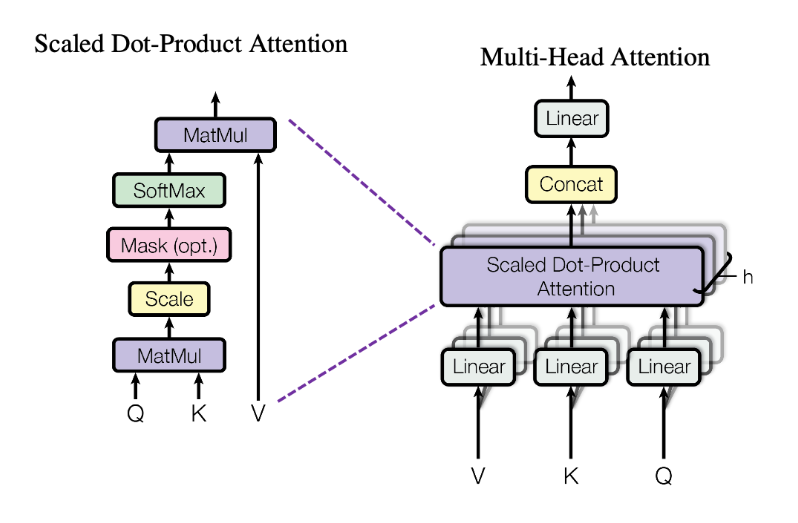
https://wikidocs.net/162098
- 어텐션(Attention)은 **세 가지 요소**를 입력으로 받는다.
  - **쿼리(queries)**
  - **키(keys)**
  - **값(values)**
  - 현재 구현에서는 Query, Key, Value의 차원이 모두 같다.
- 하이퍼 파라미터(hyperparameter)
  - **hidden_dim** : 하나의 단어에 대한 임베딩 차원
  - **n_heads** : 헤드(head)의 개수 = scaled dot-product attention의 개수
  - **dropout_ratio** : 드롭아웃(dropout) 비율

In [2]:
import torch.nn as nn


class MultiHeadAttentionLayer(nn.Module) :
  def __init__(self, hidden_dim, n_heads, dropout_ratio, device) :
    super().__init__()

    assert hidden_dim % n_heads == 0

    self.hidden_dim = hidden_dim # 임베딩 차원
    self.n_heads = n_heads # 헤드(head)의 개수 : 서로 다른 어텐션(attention) 컨셉의 수
    self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

    self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
    self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
    self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

    self.fc_o = nn.Linear(hidden_dim, hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
  
  def forward(self, query, key, value, mask = None) :
    batch_size = query.shape[0]

    # query : [batch_size, query_len, hidden_dim] 
    # key : [batch_size, key_len, hidden_dim]
    # value : [batch_size, value_len, hidden_dim]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    # Q : [batch_size, query_len, hidden_dim]
    # K : [batch_size, key_len, hidden_dim]
    # V : [batch_size, value_len, hidden_dim]

    # hidden_dim -> n_heads X head_dim 형태로 변형
    # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
    # view는 reshape 함수 느낌
    # permute는 파라미터에 인덱스를 넣어 순서 변경
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    # Q : [batch_size, n_heads, query_len, head_dim]
    # K : [batch_size, n_heads, key_len, head_dim]
    # V : [batch_size, n_heads, value_len, head_dim]

    # Attention Energy 계산 (두 tensor의 행렬곱)
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

    # energy : [batch_size, n_heads, query_len, key_len]

    # 마스크(mask)를 사용하는 경우
    # 마스크란 진짜 데이터와 더미 데이터의 위치 표시
    if mask is not None :
      # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
      energy = energy.masked_fill(mask==0, -1e10)

    # 어텐션(attention) 스코어 계산 : 각 단어에 대한 확률 값
    attention = torch.softmax(energy, dim=-1)

    # attention : [batch_size, n_heads, query_len, key_len]

    # 여기에서 Scaled Dot-Product Attention을 계산
    x = torch.matmul(self.dropout(attention), V)

    # x : [batch_size, n_heads, query_len, head_dim]

    # contiguous())는 contigous가 False인 경우(axis 순서로 자료가 저장된 상태)를 True로 변경하여 메모리 상 저장 구조 변경 
    x = x.permute(0, 2, 1, 3).contiguous()

    # x : [batch_size, query_len, n_heads, head_dim]

    x = x.view(batch_size, -1, self.hidden_dim)

    # x : [batch_size, query_len, hidden_dim]

    x = self.fc_o(x)

    # x : [batch_size, query_len, hidden_dim]

    return x, attention



In [ ]:
test_model = MultiHeadAttentionLayer(256, 8, 0.1, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
test_model

MultiHeadAttentionLayer(
  (fc_q): Linear(in_features=256, out_features=256, bias=True)
  (fc_k): Linear(in_features=256, out_features=256, bias=True)
  (fc_v): Linear(in_features=256, out_features=256, bias=True)
  (fc_o): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

### Position-wise Feedforward 아키텍처
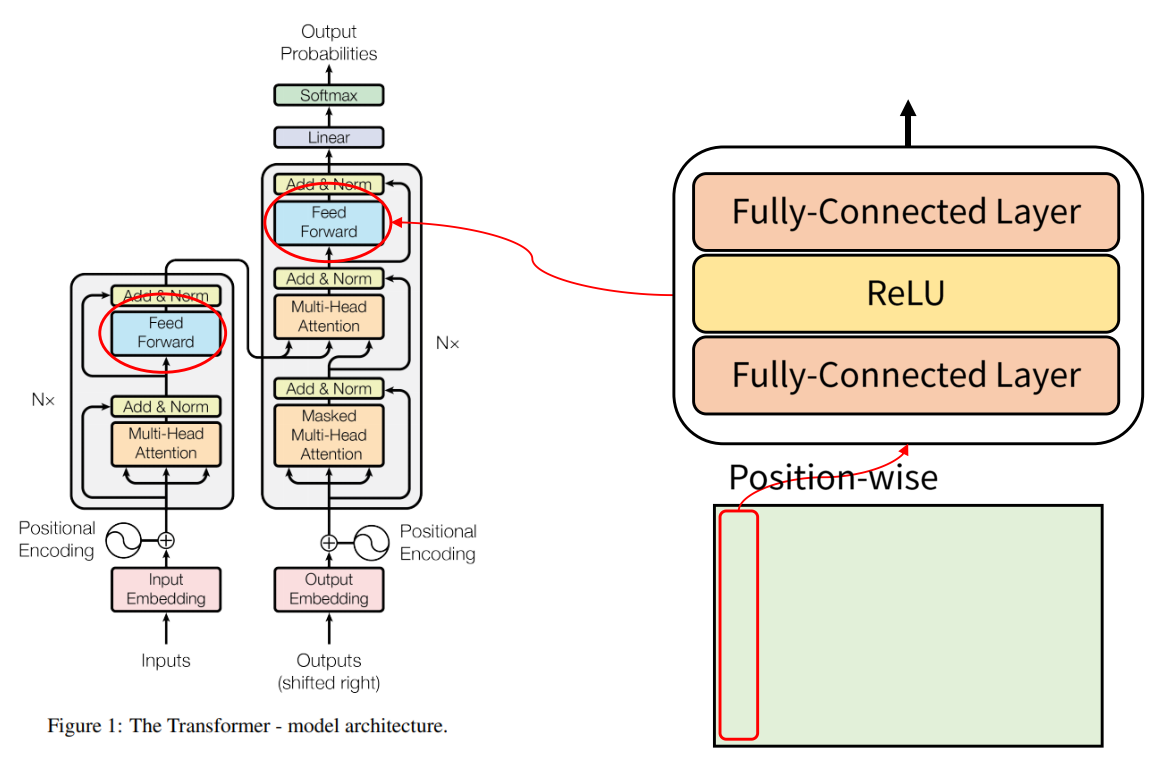
- 단어의 Position 별로 Feed Forward 한다.
- 각 단어에 해당하는 열 벡터가 입력으로 들어갔을 때, `FC-layer - Relu - FC-layer` 연산을 거치게 된다.
- 입력과 출력의 차원이 동일하다.
- 하이퍼 파라미터 (hyperparameter)
  - **hidden_dim** : 하나의 단어에 대한 임베딩 차원
  - **pf_dim** : Feedforward 레이어에서의 내부 임베딩 차원
  - **dropout_ratio** : 드롭아웃(dropout)의 비율


In [3]:
class PositionwiseFeedforwardLayer(nn.Module) :
  def __init__(self, hidden_dim, pf_dim, dropout_ratio) :
    super().__init__()

    self.fc_1 = nn.Linear(hidden_dim, pf_dim)
    self.fc_2 = nn.Linear(pf_dim, hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, x) :

    # x : [batch_size, seq_len, hidden_dim]

    x = self.dropout(torch.relu(self.fc_1(x)))

    # x : [batch_size, seq_len, pf_dim]

    x = self.fc_2(x)

    # x : [batch_size, seq_len, hidden_dim]

    return x

### 인코더(Encoder) 레이어 아키텍처
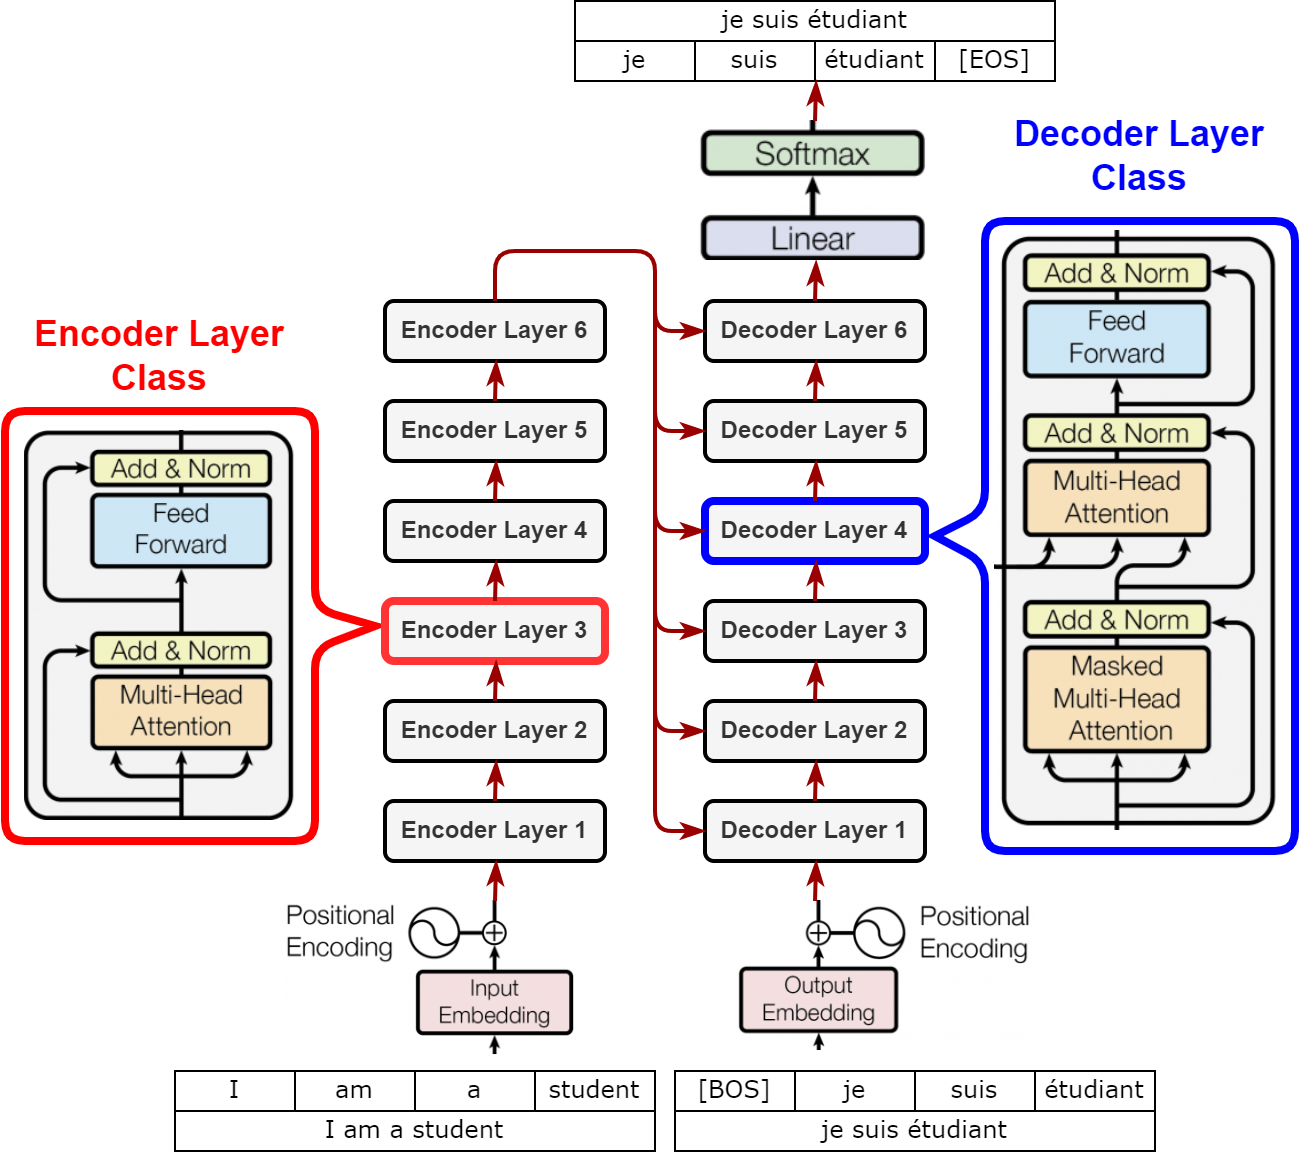
- 하나의 인코더 레이어에 대해 정의한다.
  - 입력과 출력의 차원이 같다.
  - 이러한 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용한다.
- 하이퍼 파라미터 (hyperparameter)
  - **hidden_dim** : 하나의 단어에 대한 임베딩 차원
  - **n_heads** : 헤드(head)의 개수 = scaled dot-product attention의 개수
  - **pf_dim** : Feedforward 레이어에서의 내부 임베딩 차원
  - **dropout_ratio** : 드롭아웃(dropout) 비율
- `<pad>` 토큰에 대하여 마스크(mask) 값을 0으로 설정한다.

In [7]:
class EncoderLayer(nn.Module) :
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device) :
    super().__init__()

    self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
    self.ff_layer_norm = nn.LayerNorm(hidden_dim)
    self.self_attenntion = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
    self.dropout = nn.Dropout(dropout_ratio)

  # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
  def forward(self, src, src_mask) :
    # src : [batch_size, src_len, hidden_dim]
    # src_mask : [batch_size, src_len]

    # self attention
    # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention) 할 단어를 조절 가능
    _src, _ = self.self_attention(src, src, src, src_mask)

    # dropout, residual connection and layer norm
    src = self.self_attn_layer_norm(src + self.dropout(_src))

    # src : [batch_size, src_len, hidden_dim]

    # position-wise feedforward
    _src = self.positionwise_feedforward(src)

    # dropout, residual and layer norm
    src = self.ff_layer_norm(src + self.dropout(_src))

    # src : [batch_size, src_len, hidden_dim]

    return src

### 인코더(Encoder) 아키텍처
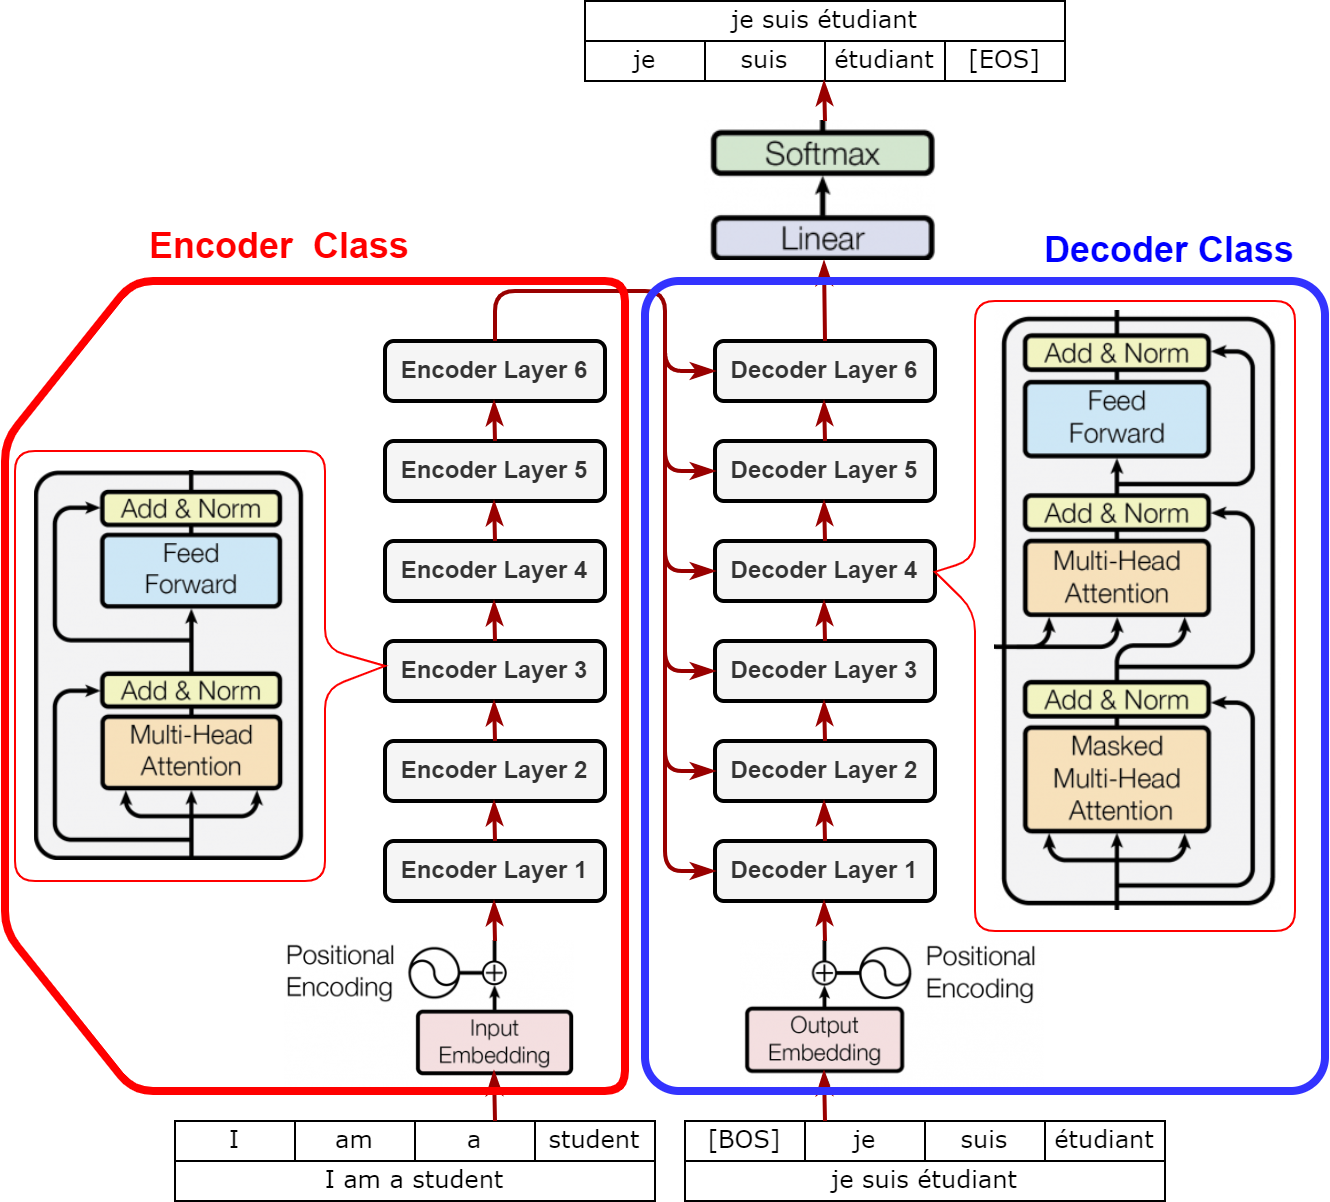
- 전체 인코더 아키텍처를 정의합니다.
- 하이퍼 파랄미터 (hyperparameter)
  - **input_dim** : 하나의 단어에 대한 원 핫 인코딩 차원
  - **hidden_dim** : 하나의 단어에 대한 임베딩 차원
  - **n_layers** : 내부적으로 사용할 인코더 레이어의 개수
  - **n_heads** : 헤드(head)의 개수 = scaled dot-product attention의 개수
  - **pf_dim** : Feedforward 레이어에서의 내부 임베딩 차원
  - **dropout_ratio** : 드롭아웃(dropout) 비율
  - **max_length** : 문장 내 최대 단어 개수
- 원본 논문과는 다르게 **위치 임베딩(positional embedding)**을 학습하는 형태로 구현한다.
  - BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식이다.
- `<pad>` 토큰에 대하여 마스크(mask) 값을 0으로 설정한다.

In [8]:
class Encoder(nn.Module) :
  def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100) :
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
    self.pos_embedding = nn.Embedding(max_length, hidden_dim)

    self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)]) 

    self.dropout = nn.Dropout(dropout_ratio)
    
    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
  
  def forward(self, src, src_mask) :

    # src : [batch_size, src_len]
    # src_mask : [batch_size, src_len]

    batch_size = src.shape[0]
    src_len = src.shape[1]

    # unsqueeze(0) : 첫 번째 차원(0번째 인덱스)에 1인 차원 추가
    pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    # pos : [batch_size, src_len]

    # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
    src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

    # src : [batch_size, src_len, hidden_dim]

    # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
    for layer in self.layers : 
      src = layer(src, src_mask)

    # src : [batch_size, src_len, hidden_dim]

    return src # 마지막 레이어의 출력을 반환
